# EDA of the dataset

### Our datasets
main dataset  - ["European Soccer Database" (ESD)](https://www.kaggle.com/hugomathien/soccer//) 

Additional datasets -

- "UK football stadiums" -  [UK stadiums description](https://www.doogal.co.uk/FootballStadiums.php//) 
- Position in league table per stage - from [worldfootball](https://www.worldfootball.net/schedule//)

The "European Soccer Database" consists of three main tables:
- Match - features for each match of 2008-2016 seasons
- Player -  player attributes
- Team - team attributes

The worldfootball dataset was extracted directly from the website. In order to receive the position of each team in each stage of the league we wrote a script named extract_table_from_url(attached together with this file) which goes through pages such as [this](http://www.worldfootball.net/schedule/eng-premier-league-2016-2017-spieltag/9/) and write the data to an csv file. 



### EDA update 

In this notebook we worked on three issues:
1) Engineering new features 
2) Dealing with draw class poor prediction rates
3) Using Different classification models


#### New features:
- points - number of points in current league stage
- norm_points - number of points in current league stage relative to highest number of points in current stage
- position - position in league table
- straight_wins - if last game was won, number of wins in a row
- straight_loses - if last game was lost, number of losses in a row
- straight_draws - - if last game ended with a draw, number of draws in a row 
- pos_goals - goals scored in last X games
- neg_goals - goals received in last X games
- tot_pos_goals - goals scored since the begining of the season
- tot_neg_goals - goals received since the begining of the season
- goals_diff - tot_pos_goals minus tot_neg_goals
- wins - wins in last X games 
- loses - loses in last X games

X is the size of the moving window we used.
In this file we set X to be 5, in the future we will try different size for X.
All of these features were created for both home and away team for each match. 

#### Draw class:
As we saw on our first attempt classifier, the classifier never chose the draw class, to deal with this issue we tried two methods, both based on demanding a certain threshold crossing for a win/ lose decision:
1) relative threshold - the threshold is determined on the percentage win and lose cases takes out of 1.
2) absolute threshold -  win/lose classed needs to cross a predetermined threshold in order for them to be picked

#### Classification models:

In order to get a perspective of the preformance we can achive, we tried using the following models:
- Logistic Regression
- KNN
- SVM
- Decision Tree
- Random Forest
- A combination of all models

After trying all of these models the best f1-score was received using Logistic Regression with the second type of threshold.



#### General Impotrs:

In [103]:
import sqlite3
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Read all DB's:

In [104]:
#Availible Leagues:
#"England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"

current_leagues = ["England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"]

#Not Availible Leagues (yet):
#Italy_Serie_A/Switzerland_Super_League

In [105]:
basic_info       = ["league","season","stage","home_team_name","away_team_name","score"]
betting_odds     = ["B365H","WHH","VCH","B365A","WHA","VCA","B365D","WHD","VCD"]
new_features     = ["points","norm_points","position","straight_wins","straight_loses","straight_draws","pos_goals","neg_goals","tot_pos_goals","tot_neg_goals","goals_diff","wins","loses"]
important_info   = basic_info + ["home_team_goal","away_team_goal"]

percent_per_season_columns = ["home_win_season_percent","home_lose_season_percent","away_win_season_percent","away_lose_season_percent"]
percent_total_columns      = ["home_win_percent","home_lose_percent","away_win_percent","away_lose_percent"]

home_away        = ["home","away"]

new_columns      = important_info + betting_odds

new_new_columns = []

for r in itertools.product(home_away,new_features): new_new_columns.append(r[0] +"_"+ r[1])

In [106]:
features_list = new_new_columns + percent_per_season_columns + percent_total_columns + betting_odds # + ["stage"]
labels_list   = "win_lose_draw"

In [107]:
final_matches_db = pd.read_csv("databases/my_matches_db.csv", encoding='latin-1', index_col = [0])

In [108]:
all_leagues = final_matches_db["league"].unique()

for league in all_leagues:
    if league.replace(" ","_") in current_leagues: continue
    final_matches_db = final_matches_db[final_matches_db["league"] != league]

In [109]:
final_matches_db

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.000000,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.50,4.50,5.50,0
1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.000000,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.50,5.50,6.00,1
2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.000000,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.60,3.30,3.80,2
3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.000000,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.40,3.20,3.50,1
4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.000000,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.40,3.20,3.50,1
5,England Premier League,2008/2009,1,Everton,Blackburn Rovers,2 - 3,0.0,0.000000,0.0,0.0,...,2.00,1.95,2.05,4.00,3.50,4.00,3.30,3.10,3.30,2
6,England Premier League,2008/2009,1,Middlesbrough,Tottenham Hotspur,2 - 1,0.0,0.000000,0.0,0.0,...,3.20,2.90,3.20,2.25,2.15,2.30,3.40,3.20,3.40,1
7,England Premier League,2008/2009,1,Bolton Wanderers,Stoke City,3 - 1,0.0,0.000000,0.0,0.0,...,1.83,1.80,1.85,4.50,4.00,4.80,3.50,3.10,3.40,1
8,England Premier League,2008/2009,1,Hull City,Fulham,2 - 1,0.0,0.000000,0.0,0.0,...,2.60,2.50,2.60,2.80,2.62,2.80,3.20,2.90,3.40,1
9,England Premier League,2008/2009,1,Chelsea,Portsmouth,4 - 0,0.0,0.000000,0.0,0.0,...,1.33,1.30,1.33,10.00,8.50,11.00,5.00,4.20,5.00,1


#### Functions:

#### Hyperparameters:

In [110]:
#window_size = 5
threshold_1 = 1.5
threshold_2 = {1:0.45,2:0.35}

#### Data Visualizations:

In [111]:
#sns.pairplot(new_matches[features_list].dropna(axis=0))

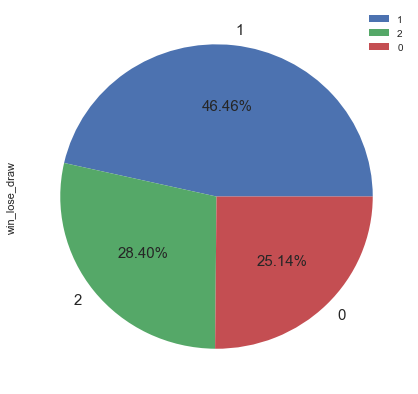

In [112]:
final_matches_db["win_lose_draw"].value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)

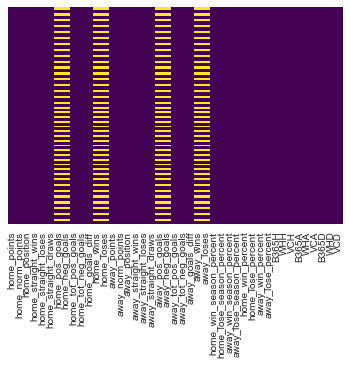

In [113]:
sns.heatmap(final_matches_db[features_list].isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Split the data:

In [114]:
def my_train_test_split(features, labels, test_size):   
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_leagues = features["league"].unique()
    for league in all_leagues:
        min_stage = features[features["league"] == league]["stage"].min()
        max_stage = features[features["league"] == league]["stage"].max()
        
        num_of_stages    = max_stage - min_stage + 1
        test_num_stages  = round(num_of_stages*test_size)
        train_num_stages = num_of_stages-test_num_stages
    
        X_train[league] = features[features["stage"] <= (min_stage + train_num_stages)].drop(["league","stage"],axis=1)
        X_test[league]  = features[features["stage"] >= (max_stage - test_num_stages + 1)].drop(["league","stage"],axis=1)
        y_train[league] = labels[labels["stage"] <= (min_stage + train_num_stages)]["win_lose_draw"]
        y_test[league]  = labels[labels["stage"] >= (max_stage - test_num_stages + 1)]["win_lose_draw"]
        
    return pd.concat(X_train,ignore_index=True),pd.concat(X_test,ignore_index=True),pd.concat(y_train,ignore_index=True),pd.concat(y_test,ignore_index=True)

In [115]:
temp     = final_matches_db.dropna(axis = 0)
features = temp[features_list]
labels   = temp[labels_list]

#temp_feat = temp[["league","stage"] + features_list]
#temp_labe = temp[["league","stage"] + [labels_list]]

In [116]:
print("Num of features =",len(features_list))

Num of features = 43


In [117]:
from sklearn.model_selection import train_test_split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.40, random_state=103)

In [119]:
#X_train, X_test, y_train, y_test = my_train_test_split(temp_feat, temp_labe, 0.4)

####  Logistic Regression model

In [120]:
from sklearn.linear_model import LogisticRegression

In [121]:
logmodel = LogisticRegression()

In [122]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [123]:
predictions = logmodel.predict(X_test)

#### Learning Evaluation:

In [124]:
from sklearn.metrics import classification_report,confusion_matrix

In [125]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.26      0.02      0.04       878
          1       0.54      0.86      0.67      1620
          2       0.51      0.42      0.46       953

avg / total       0.46      0.53      0.45      3451



In [126]:
print(confusion_matrix(y_test,predictions))

[[  19  654  205]
 [  34 1398  188]
 [  20  531  402]]


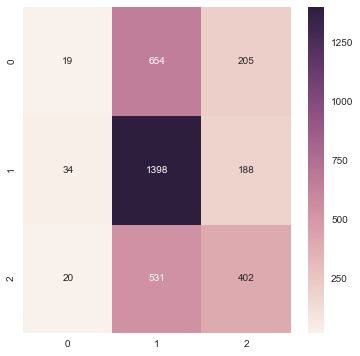

In [127]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True, fmt="d")

In [128]:
coeff_df = pd.DataFrame(logmodel.coef_.T,features.columns,
                        columns=['Coefficient_home','Coefficient_away','Coefficient_draw'])
coeff_df

,Coefficient_home,Coefficient_away,Coefficient_draw
home_points,0.019876,-0.005386,-0.015000
home_norm_points,-0.066432,-0.049588,0.048457
home_position,0.027244,-0.001560,-0.032376
home_straight_wins,-0.012295,0.059624,-0.084595
home_straight_loses,0.010229,-0.014834,0.001601
home_straight_draws,0.078216,-0.030729,-0.058651
home_pos_goals,-0.022584,-0.005869,0.029836
home_neg_goals,0.008981,0.007525,-0.017843
home_tot_pos_goals,-0.007141,0.005054,0.001986
home_tot_neg_goals,-0.006460,0.005537,0.000138


#### Adding thresold to Logistic Regression model

In [129]:
soft_decision = logmodel.predict_proba(X_test)

In [130]:
def thresh_1(probs,threshold):
    decision  = -1
    if max(probs) == probs[0]: decision = 0
    else:
        home_away_probs = list(probs[[1,2]])
        if max(home_away_probs) > threshold*min(home_away_probs): decision = (home_away_probs.index(max(home_away_probs)) + 1)
    if decision == -1: decision = 0
    return decision

def thresh_2(probs,threshold):
    decision  = -1
    if    probs[1] > threshold[1]: decision = 1
    elif  probs[2] > threshold[2]: decision = 2
    else:                          decision = 0
    return decision

In [131]:
new_predictions = {"threshold_1":[],"threshold_2":[]}

for aa in range(len(soft_decision)):
    new_predictions["threshold_1"].append(thresh_1(soft_decision[aa],threshold_1))
    new_predictions["threshold_2"].append(thresh_2(soft_decision[aa],threshold_2))

In [132]:
for thresh,prediction in new_predictions.items():
    print("threshold =",thresh)
    print(classification_report(y_test,prediction))
    print(confusion_matrix(y_test,prediction),"\n\n")

threshold = threshold_2
             precision    recall  f1-score   support

          0       0.27      0.25      0.26       878
          1       0.60      0.65      0.62      1620
          2       0.49      0.45      0.47       953

avg / total       0.49      0.49      0.49      3451

[[ 223  423  232]
 [ 351 1052  217]
 [ 242  279  432]] 


threshold = threshold_1
             precision    recall  f1-score   support

          0       0.29      0.33      0.31       878
          1       0.58      0.72      0.64      1620
          2       0.60      0.28      0.38       953

avg / total       0.51      0.50      0.49      3451

[[ 290  493   95]
 [ 370 1165   85]
 [ 340  345  268]] 




#### Adding more models:

In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### KNN:

In [134]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

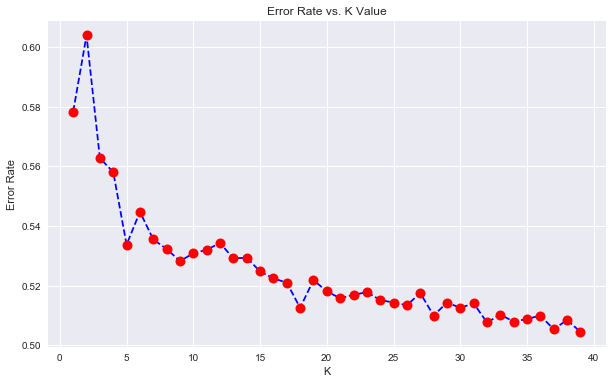

In [135]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [136]:
best_n_neighbors = error_rate.index(min(error_rate))+1
print("best_n_neighbors =",best_n_neighbors)

best_n_neighbors = 39


In [137]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)

#### SVM:

In [138]:
svm = SVC()

In [139]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001]} 
svm_grid   = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

#### Decision Tree:

In [140]:
dtree = DecisionTreeClassifier()

In [141]:
rfc = RandomForestClassifier(n_estimators=600)

#### Train and Predict using all model:

In [142]:
all_models         = [knn,svm,svm_grid,rfc,dtree]
models_predictions = {}

for thresh,prediction in new_predictions.items():
    models_predictions[str(logmodel).split("(")[0] + " " + thresh] = prediction

for model in all_models:
    classifier_name = str(model).split("(")[0]
    model.fit(X_train,y_train)
    models_predictions[classifier_name] = model.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] gamma=1, C=0.1 ..................................................
[CV] ................... gamma=1, C=0.1, score=0.470452, total=   2.6s
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................... gamma=1, C=0.1, score=0.470725, total=   2.6s
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV] ................... gamma=1, C=0.1, score=0.470998, total=   2.3s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.470452, total=   1.7s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.470725, total=   2.0s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.470998, total=   1.9s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.470452, total=   1.4s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.470725, total=   1.5s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.470998, total=   1.4s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] .

[CV] .................. gamma=1, C=1000, score=0.470452, total=   2.4s
[CV] gamma=1, C=1000 .................................................
[CV] .................. gamma=1, C=1000, score=0.470725, total=   2.4s
[CV] gamma=1, C=1000 .................................................
[CV] .................. gamma=1, C=1000, score=0.470998, total=   2.5s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.470452, total=   1.6s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.470725, total=   1.7s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.470998, total=   1.7s
[CV] gamma=0.01, C=1000 ..............................................
[CV] ............... gamma=0.01, C=1000, score=0.447277, total=   1.6s
[CV] gamma=0.01, C=1000 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  3.6min finished


In [143]:
for model_name,model_prediction in models_predictions.items():
    print("classifier =",model_name)
    print(classification_report(y_test,model_prediction))
    print(confusion_matrix(y_test,model_prediction),"\n\n")

classifier = KNeighborsClassifier
             precision    recall  f1-score   support

          0       0.28      0.09      0.13       878
          1       0.53      0.78      0.63      1620
          2       0.47      0.38      0.42       953

avg / total       0.45      0.50      0.45      3451

[[  76  622  180]
 [ 123 1268  229]
 [  76  511  366]] 


classifier = SVC
             precision    recall  f1-score   support

          0       0.35      0.01      0.02       878
          1       0.47      0.98      0.64      1620
          2       0.28      0.01      0.03       953

avg / total       0.39      0.47      0.31      3451

[[   8  858   12]
 [   8 1590   22]
 [   7  933   13]] 


classifier = LogisticRegression threshold_1
             precision    recall  f1-score   support

          0       0.29      0.33      0.31       878
          1       0.58      0.72      0.64      1620
          2       0.60      0.28      0.38       953

avg / total       0.51      0.50      0

In [144]:
# models: rfc/knn/logmodel/dtree/svm/svm_grid
chosen_model = rfc
chosen_data  = X_test
soft_decision = chosen_model.predict_proba(chosen_data)
hard_decision = chosen_model.predict(chosen_data)

In [145]:
soft_decision_df = pd.DataFrame(soft_decision,index = chosen_data.index,columns = ["MYD","MYH","MYA"])
hard_decision_df = pd.DataFrame(hard_decision,index = chosen_data.index)
#soft_decision_df["predictions"] = hard_decision_df[0]

soft_decision_df.to_csv("databases/my_predictions.csv")

#### Combine all predictions:

In [146]:
"""asi = {}
asi["LogisticRegression"] = models_predictions["LogisticRegression"]
asi["GridSearchCV"] = models_predictions["GridSearchCV"]
asi["RandomForestClassifier"] = models_predictions["RandomForestClassifier"]"""

'asi = {}\nasi["LogisticRegression"] = models_predictions["LogisticRegression"]\nasi["GridSearchCV"] = models_predictions["GridSearchCV"]\nasi["RandomForestClassifier"] = models_predictions["RandomForestClassifier"]'

In [147]:
"""num_of_clasifers  = len(asi)
len_of_prediction = len(X_test)

all_predictions = np.concatenate(list(asi.values()),axis=0)
all_predictions = all_predictions.reshape(num_of_clasifers,len_of_prediction).T"""

'num_of_clasifers  = len(asi)\nlen_of_prediction = len(X_test)\n\nall_predictions = np.concatenate(list(asi.values()),axis=0)\nall_predictions = all_predictions.reshape(num_of_clasifers,len_of_prediction).T'

In [148]:
num_of_clasifers  = len(models_predictions)
len_of_prediction = len(X_test)

all_predictions = np.concatenate(list(models_predictions.values()),axis=0)
all_predictions = all_predictions.reshape(num_of_clasifers,len_of_prediction).T

In [149]:
final_predictions = []
for i in range(0,len_of_prediction):
    predicted_class,count = np.unique(all_predictions[i],return_counts=True)
    dic = dict(zip(predicted_class,count))
    if 0 in list(dic) and dic[0] > 1: final_class = 0
    else: final_class = max(dic)
    final_predictions.append(final_class)

In [150]:
print(classification_report(y_test,final_predictions))
print(confusion_matrix(y_test,final_predictions))

             precision    recall  f1-score   support

          0       0.28      0.28      0.28       878
          1       0.62      0.54      0.58      1620
          2       0.40      0.50      0.45       953

avg / total       0.48      0.46      0.47      3451

[[249 321 308]
 [355 870 395]
 [270 206 477]]


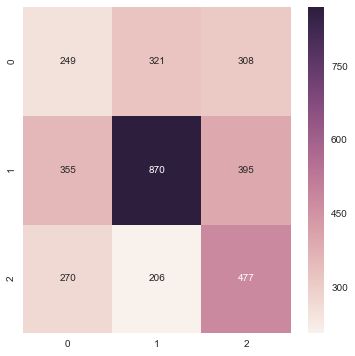

In [151]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test,final_predictions),annot=True, fmt="d")

#### Nueral Network model